In [1]:
import math
import itertools

import pandas as pd
from sqlalchemy.sql import select

from predict_aqi.load_data import (
    AirLocation, get_db_session, load_air_location_data, load_measurement_data,
    load_nearby_location_data
)

# Select some airlocation with bad aqi
session = get_db_session()
s = select([AirLocation]).where(AirLocation.aqi > 100)
some_airlocation_ids = [x['id'] for x in session.execute(s)]

/opt/conda/lib/python3.5/site-packages/sqlalchemy/dialects/postgresql/base.py:2503: SAWarning: Did not recognize type 'geometry' of column 'coordinates'
  (attype, name))


In [2]:
# Select classifier to use
from sklearn.neural_network import MLPRegressor
from predict_aqi.single_city_model import generate_AQI_inputs_and_outputs
from predict_aqi import config


indices_ahead_to_predict = range(2, config.NUMBER_AHEAD_TO_PREDICT + 2, 2)
indices_behind_to_use = range(1, 48)


def load_data_for_airlocation(airlocation_id):
    some_airlocation = load_air_location_data(airlocation_id)
    
    print("Loading {}, {}".format(some_airlocation.short_name, some_airlocation.en_country_name))
    
    measurements = load_measurement_data(airlocation_id)
    df, input_columns, output_columns = generate_AQI_inputs_and_outputs(
        measurements, indices_behind_to_use, indices_ahead_to_predict
    )
    return df, input_columns, output_columns

In [3]:
locations = load_nearby_location_data(2110, 50)[0:5]
print([x for x in locations])

[(2110, 0.0), (1587, 0.0825321427082304), (1671, 0.0864056419512064), (1952, 0.126131901285912), (1561, 0.149613850779269)]


In [4]:
city_1 = load_air_location_data(locations[0][0])
city_2 = load_air_location_data(locations[3][0])
print("City 1: {}".format(city_1['short_name']))
print("City 2: {}".format(city_2['short_name']))

City 1: Beijing/海淀北京植物园
City 2: Beijing/门头沟龙泉镇


In [5]:
city_1_data = load_measurement_data(city_1['id'])
city_2_data = load_measurement_data(city_2['id'])

In [23]:
city_1_data.columns = ['city_1_id', 'city_1_measurement_datetime', 'city_1_aqi']
city_2_data.columns = ['city_2_id', 'city_2_measurement_datetime', 'city_2_aqi']
df = city_1_data.join(city_2_data)


def row_has_same_time(row, number_of_cities):
    '''
    Returns whether the row has all times within 10 minutes of the base city
    '''
    ten_minutes = 60 * 10 * 10**9
    for city_number in range(2, number_of_cities + 1):
        diff = abs(
            row['city_1_measurement_datetime'].value - 
            row['city_{}_measurement_datetime'.format(city_number)].value
        )
        if diff > ten_minutes:
            return False
    return True

from operator import itemgetter
def get_city_with_smallest_time(row, number_of_cities):
    row_names = ['city_{}_measurement_datetime'.format(i) 
                 for i in range(1, number_of_cities + 1)]
    return min(enumerate(row[row_names]), key=itemgetter(1))[0] + 1

import numpy as np
def city_has_no_more_data(row, city_index):
    return np.isnan(row['city_{}_id'.format(city_index)])


def shift_city_up(df, shift_index, city_index):
    city_columns = [s.format(city_index) for s in
                    ['city_{}_id', 'city_{}_measurement_datetime', 'city_{}_aqi']]
    df[city_columns] = df[city_columns].shift(-1)

        
print(df.loc[0])
print(df.count()[0])
print(row_has_same_time(df.loc[0], 2))
print(get_city_with_smallest_time(df.loc[0], 2))
print(city_has_no_more_data(df.loc[0], 2))
print(city_has_no_more_data(df.loc[37100], 2))

x = df.loc[9]['city_1_id']
y = df.loc[10]['city_1_id']
shift_city_up(df, 10, 1)

assert df.loc[10]['city_1_id'] != y, "Shift up didn't shift"
assert df.loc[9]['city_1_id'] == x, "Shift up shifted too much"

city_1_id                                                  2110
city_1_measurement_datetime    2016-01-24 18:40:05.051686+00:00
city_1_aqi                                                   25
city_2_id                                                  1952
city_2_measurement_datetime    2016-01-24 18:40:04.183895+00:00
city_2_aqi                                                   53
Name: 0, dtype: object
37114
True
2
False
True


AssertionError: Shift up shifted too much

In [7]:
def asdf(df, number_of_cities):
    continuous_time_series = []
    start_index = 0
    current_index = 0
    while df.count()[0] > current_index:
        current_index += 1
        row = df.loc[current_index]
        if not row_has_same_time(row, number_of_cities):
            continuous_time_series.append((start_index, current_index))
            while not row_has_same_time(row, number_of_cities):
                city_to_shift = get_city_with_smallest_time(row, number_of_cities)
                shift_city_up(df, current_index, city_to_shift)
                row = df.loc[current_index]
                if city_has_no_more_data(row, city_to_shift):
                    return df, continuous_time_series
            start_index = current_index
    continuous_time_series.append((start_index, current_index))
    return df, continuous_time_series
df, continuous_time_series = asdf(df, 2)
print(continuous_time_series)
    
'''
chunks = []
chunk_start = 0
chunk_end = 0
while has_more_rows():
    chunk_end += 1
    curr_row = get_next_row()
    if not row_has_same_time():
        chunks.append((chunk_start, chunk_end))
        while not row_has_same_time():
            city_index = get_city_with_smallest_time()
            shift_city_up(city_index)
            if city_has_no_more_data(city_index):
                return
        chunk_start = chunk_end
'''

[(0, 3), (3, 1531), (1531, 2607), (2607, 3013), (3013, 3051), (3051, 3246), (3246, 10699), (10699, 11010), (11010, 11283), (11283, 12738), (12738, 13308), (13308, 13441), (13441, 14691), (14691, 15884), (15884, 17308), (17308, 17493), (17493, 19650), (19650, 19698), (19698, 19791), (19791, 27333), (27333, 29071), (29071, 29131), (29131, 29319), (29319, 29539), (29539, 31801), (31801, 31941), (31941, 32713), (32713, 36362), (36362, 36501)]


'\nchunks = []\nchunk_start = 0\nchunk_end = 0\nwhile has_more_rows():\n    chunk_end += 1\n    curr_row = get_next_row()\n    if not row_has_same_time():\n        chunks.append((chunk_start, chunk_end))\n        while not row_has_same_time():\n            city_index = get_city_with_smallest_time()\n            shift_city_up(city_index)\n            if city_has_no_more_data(city_index):\n                return\n        chunk_start = chunk_end\n'

In [18]:
import matplotlib.pyplot as plt


def generate_data_graph(dfs, axis_range=None):
    plt.figure(figsize=(15, 10))
    if not axis_range:
        axis_range = [0.0, 120000000.0, 0.0, 250.0] 
    plt.axis(axis_range)
    for index, df in enumerate(dfs):
        plt.scatter(
            df['city_1_id'],
            df['city_1_aqi'], 
            label="city 1 cleaned aqi over time",
            color=str((len(dfs) - index) / (len(dfs) + 1)),
            s=2, lw=1
        )
        plt.scatter(
            df['city_2_id'],
            df['city_2_aqi'], 
            label="city 2 cleaned aqi over time",
            color=str(index / (len(dfs) + 1)),
            s=2, lw=1
        )
    #plt.legend(loc=6, bbox_to_anchor=(0, 0.3))
    #plt.suptitle("Absolute AQI error on predictions for the next 24 hours", fontsize=20)

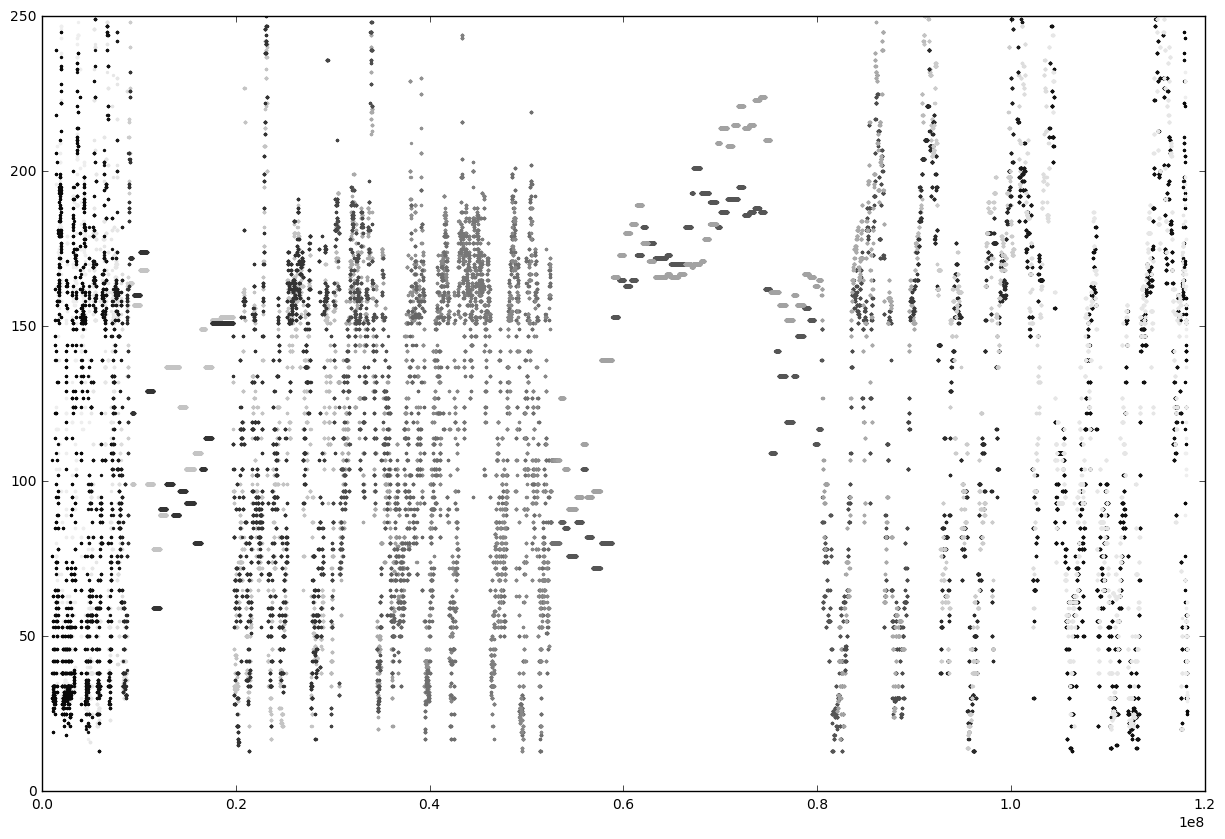

In [19]:
generate_data_graph([df[i:j] for i, j in continuous_time_series], [0.0, 120000000.0, 0.0, 250.0])